In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Simple 4-bit binary patterns
# Class 0: Patterns with more 1s on the left
# Class 1: Patterns with more 1s on the right

X_train = torch.tensor([
    [1, 1, 0, 0],  # Class 0: Left heavy
    [1, 0, 0, 0],  # Class 0: Left heavy
    [0, 0, 1, 1],  # Class 1: Right heavy
    [0, 0, 0, 1],  # Class 1: Right heavy
], dtype=torch.float32)

y_train = torch.tensor([[0], [0], [1], [1]], dtype=torch.float32)

print("Training Data:")
print(f"X shape: {X_train.shape}")
print(f"y shape: {y_train.shape}")
print("\nPatterns:")
for i in range(len(X_train)):
    print(f"  {X_train[i].int().tolist()} -> Class {int(y_train[i].item())}")

Training Data:
X shape: torch.Size([4, 4])
y shape: torch.Size([4, 1])

Patterns:
  [1, 1, 0, 0] -> Class 0
  [1, 0, 0, 0] -> Class 0
  [0, 0, 1, 1] -> Class 1
  [0, 0, 0, 1] -> Class 1


In [3]:
def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + torch.exp(-torch.clamp(x, -50, 50)))

class RBM:
    """
    Restricted Boltzmann Machine.
    """
    def __init__(self, n_visible, n_hidden):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        
        # Initialize weights and biases
        self.W = torch.randn(n_visible, n_hidden) * 0.1
        self.a = torch.zeros(n_visible)  # Visible bias
        self.b = torch.zeros(n_hidden)   # Hidden bias
    
    def sample_hidden(self, v):
        """
        Sample hidden units given visible units.
        P(h=1|v) = sigmoid(b + v @ W)
        """
        activation = torch.matmul(v, self.W) + self.b
        p_h_given_v = sigmoid(activation)
        # Sample binary hidden states
        h_sample = (torch.rand_like(p_h_given_v) < p_h_given_v).float()
        return p_h_given_v, h_sample
    
    def sample_visible(self, h):
        """
        Sample visible units given hidden units.
        P(v=1|h) = sigmoid(a + h @ W^T)
        """
        activation = torch.matmul(h, self.W.T) + self.a
        p_v_given_h = sigmoid(activation)
        # Sample binary visible states
        v_sample = (torch.rand_like(p_v_given_h) < p_v_given_h).float()
        return p_v_given_h, v_sample
    
    def contrastive_divergence(self, v0, k=1, lr=0.1):
        """
        Contrastive Divergence (CD-k) training step.
        
        Args:
            v0: Input data (batch of visible vectors)
            k: Number of Gibbs sampling steps
            lr: Learning rate
        """
        batch_size = v0.shape[0]
        
        # Positive phase: data -> hidden
        ph0, h0 = self.sample_hidden(v0)
        
        # Gibbs sampling: k steps
        hk = h0
        for _ in range(k):
            pvk, vk = self.sample_visible(hk)
            phk, hk = self.sample_hidden(vk)
        
        # Compute gradients
        # Positive associations (data)
        positive = torch.matmul(v0.T, ph0)
        # Negative associations (reconstruction)
        negative = torch.matmul(vk.T, phk)
        
        # Update weights and biases
        self.W += lr * (positive - negative) / batch_size
        self.a += lr * torch.mean(v0 - vk, dim=0)
        self.b += lr * torch.mean(ph0 - phk, dim=0)
        
        # Compute reconstruction error
        error = torch.mean((v0 - pvk) ** 2)
        return error.item()
    
    def transform(self, v):
        """Get hidden activations (for stacking RBMs)."""
        p_h, _ = self.sample_hidden(v)
        return p_h

print("RBM class defined!")
print("\nKey methods:")
print("  sample_hidden(v): v -> h")
print("  sample_visible(h): h -> v")
print("  contrastive_divergence(): Train RBM")
print("  transform(v): Get hidden features")

RBM class defined!

Key methods:
  sample_hidden(v): v -> h
  sample_visible(h): h -> v
  contrastive_divergence(): Train RBM
  transform(v): Get hidden features


In [4]:
# Create a simple RBM
rbm_test = RBM(n_visible=4, n_hidden=3)

print("RBM Structure:")
print(f"  Visible units: {rbm_test.n_visible}")
print(f"  Hidden units: {rbm_test.n_hidden}")
print(f"  Weight shape: {rbm_test.W.shape}")

# Test forward (visible -> hidden)
test_v = X_train[0:1]  # First sample
print(f"\nInput visible: {test_v.squeeze().tolist()}")

p_h, h = rbm_test.sample_hidden(test_v)
print(f"Hidden probabilities: {p_h.squeeze().tolist()}")
print(f"Hidden samples: {h.squeeze().int().tolist()}")

# Test backward (hidden -> visible)
p_v, v = rbm_test.sample_visible(h)
print(f"\nReconstructed probabilities: {p_v.squeeze().tolist()}")
print(f"Reconstructed samples: {v.squeeze().int().tolist()}")

RBM Structure:
  Visible units: 4
  Hidden units: 3
  Weight shape: torch.Size([4, 3])

Input visible: [1.0, 1.0, 0.0, 0.0]
Hidden probabilities: [0.5141717791557312, 0.47516927123069763, 0.5012033581733704]
Hidden samples: [1, 1, 1]

Reconstructed probabilities: [0.5174919366836548, 0.4730548560619354, 0.5506224632263184, 0.540203332901001]
Reconstructed samples: [1, 0, 1, 0]


In [5]:
def train_rbm(rbm, data, epochs=100, lr=0.1, k=1):
    """
    Train RBM using Contrastive Divergence.
    """
    errors = []
    
    for epoch in range(epochs):
        error = rbm.contrastive_divergence(data, k=k, lr=lr)
        errors.append(error)
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch:4d} | Reconstruction Error: {error:.6f}")
    
    return errors

# Train first RBM
torch.manual_seed(42)
rbm1 = RBM(n_visible=4, n_hidden=3)

print("Training RBM Layer 1 (4 -> 3)...")
print("="*50)
errors1 = train_rbm(rbm1, X_train, epochs=100, lr=0.5)
print(f"\nFinal Error: {errors1[-1]:.6f}")

Training RBM Layer 1 (4 -> 3)...
Epoch    0 | Reconstruction Error: 0.257310
Epoch   20 | Reconstruction Error: 0.211030
Epoch   40 | Reconstruction Error: 0.193630
Epoch   60 | Reconstruction Error: 0.182887
Epoch   80 | Reconstruction Error: 0.213050

Final Error: 0.156228


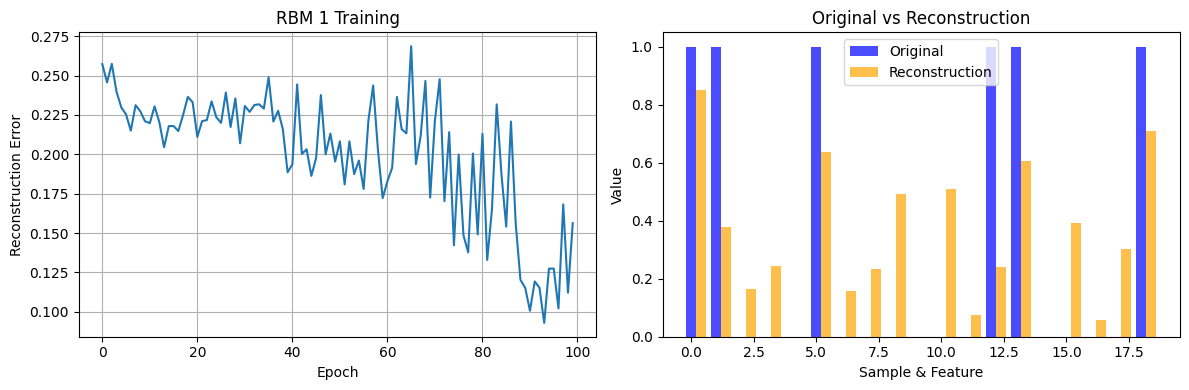

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot reconstruction error
axes[0].plot(errors1)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Reconstruction Error')
axes[0].set_title('RBM 1 Training')
axes[0].grid(True)

# Show reconstructions
axes[1].set_title('Original vs Reconstruction')
for i in range(len(X_train)):
    p_h, h = rbm1.sample_hidden(X_train[i:i+1])
    p_v, _ = rbm1.sample_visible(h)
    
    axes[1].bar(np.arange(4) + i*5, X_train[i].numpy(), width=0.4, label=f'Original {i}' if i==0 else '', color='blue', alpha=0.7)
    axes[1].bar(np.arange(4) + i*5 + 0.4, p_v.squeeze().detach().numpy(), width=0.4, label=f'Recon {i}' if i==0 else '', color='orange', alpha=0.7)

axes[1].set_xlabel('Sample & Feature')
axes[1].set_ylabel('Value')
axes[1].legend(['Original', 'Reconstruction'])

plt.tight_layout()
plt.show()

In [7]:
class DBN:
    """
    Deep Belief Network: Stack of RBMs + Classifier.
    """
    def __init__(self, layer_sizes):
        """
        Args:
            layer_sizes: List of layer sizes [input, hidden1, hidden2, ...]
        """
        self.layer_sizes = layer_sizes
        self.rbms = []
        
        # Create RBMs for each pair of layers
        for i in range(len(layer_sizes) - 1):
            rbm = RBM(layer_sizes[i], layer_sizes[i+1])
            self.rbms.append(rbm)
        
        # Classifier weights (for fine-tuning)
        self.classifier_W = None
        self.classifier_b = None
    
    def pretrain(self, X, epochs=100, lr=0.1):
        """
        Greedy layer-wise pretraining.
        Train each RBM in sequence.
        """
        print("\n" + "="*60)
        print("GREEDY LAYER-WISE PRETRAINING")
        print("="*60)
        
        all_errors = []
        current_input = X
        
        for i, rbm in enumerate(self.rbms):
            print(f"\n--- Training RBM {i+1}: {rbm.n_visible} -> {rbm.n_hidden} ---")
            
            errors = []
            for epoch in range(epochs):
                error = rbm.contrastive_divergence(current_input, k=1, lr=lr)
                errors.append(error)
                
                if epoch % 20 == 0:
                    print(f"  Epoch {epoch:4d} | Error: {error:.6f}")
            
            all_errors.append(errors)
            
            # Use current RBM's hidden activations as input to next RBM
            current_input = rbm.transform(current_input)
        
        return all_errors
    
    def transform(self, X):
        """
        Forward pass through all RBMs to get final hidden representation.
        """
        h = X
        for rbm in self.rbms:
            h = rbm.transform(h)
        return h
    
    def init_classifier(self, n_classes):
        """
        Initialize classifier on top of DBN.
        """
        last_hidden_size = self.layer_sizes[-1]
        self.classifier_W = torch.randn(last_hidden_size, n_classes) * 0.1
        self.classifier_b = torch.zeros(n_classes)
    
    def forward(self, X):
        """
        Full forward pass: RBMs + Classifier.
        """
        # Get deep features from RBMs
        h = self.transform(X)
        
        # Classifier
        logits = torch.matmul(h, self.classifier_W) + self.classifier_b
        predictions = sigmoid(logits)
        
        return predictions, h

print("DBN class defined!")
print("\nKey methods:")
print("  pretrain(): Greedy layer-wise training")
print("  transform(): Get deep features")
print("  forward(): Full network prediction")

DBN class defined!

Key methods:
  pretrain(): Greedy layer-wise training
  transform(): Get deep features
  forward(): Full network prediction


In [ ]:
# DBN Architecture: 4 -> 3 -> 2
torch.manual_seed(42)
dbn = DBN([4, 3, 2])

print("DBN Architecture:")
print(f"  Input: 4 features")
for i, rbm in enumerate(dbn.rbms):
    print(f"  RBM {i+1}: {rbm.n_visible} -> {rbm.n_hidden}")

# Pretrain
pretrain_errors = dbn.pretrain(X_train, epochs=100, lr=0.5)

DBN Architecture:
  Input: 4 features
  RBM 1: 4 -> 3
  RBM 2: 3 -> 2

GREEDY LAYER-WISE PRETRAINING

--- Training RBM 1: 4 -> 3 ---
  Epoch    0 | Error: 0.259440
  Epoch   20 | Error: 0.219030
  Epoch   40 | Error: 0.221981
  Epoch   60 | Error: 0.218268
  Epoch   80 | Error: 0.214804

--- Training RBM 2: 3 -> 2 ---
  Epoch    0 | Error: 0.023894
  Epoch   20 | Error: 0.016045
  Epoch   40 | Error: 0.020914
  Epoch   60 | Error: 0.022294
  Epoch   80 | Error: 0.021918


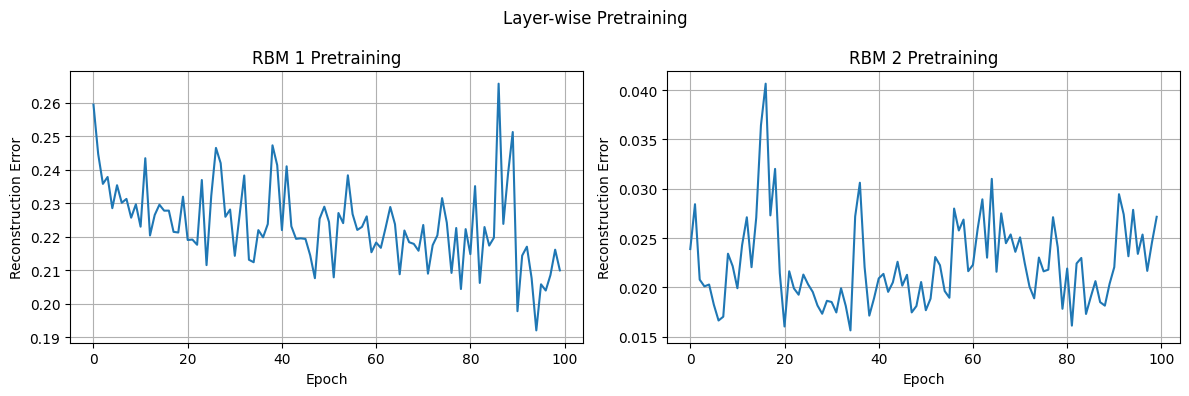

In [9]:
fig, axes = plt.subplots(1, len(pretrain_errors), figsize=(12, 4))

for i, errors in enumerate(pretrain_errors):
    axes[i].plot(errors)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Reconstruction Error')
    axes[i].set_title(f'RBM {i+1} Pretraining')
    axes[i].grid(True)

plt.suptitle('Layer-wise Pretraining')
plt.tight_layout()
plt.show()

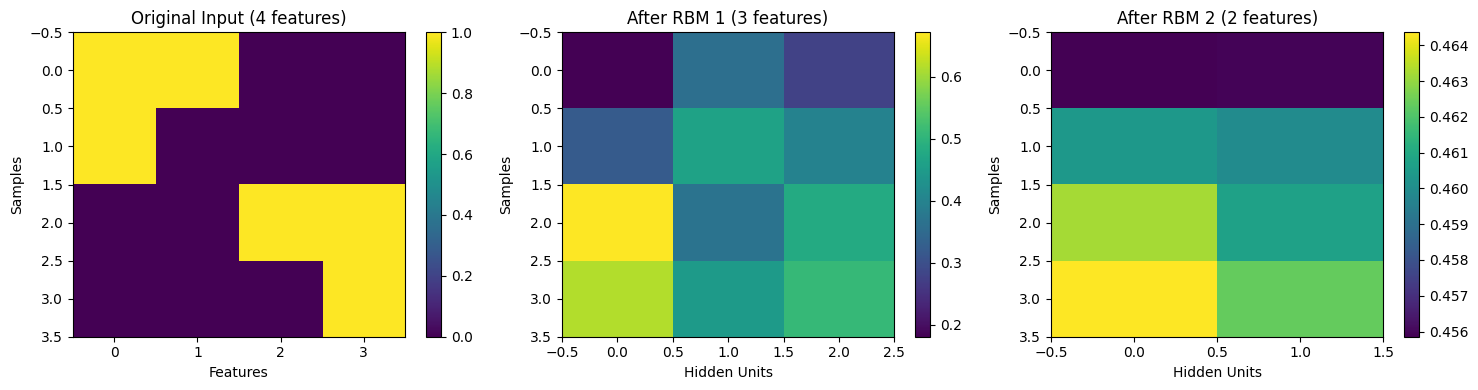


Deep representations learned without labels!
Original: torch.Size([4, 4]) -> After RBM1: torch.Size([4, 3]) -> After RBM2: torch.Size([4, 2])


In [10]:
# Get representations at each layer
h1 = dbn.rbms[0].transform(X_train)  # After RBM 1
h2 = dbn.rbms[1].transform(h1)       # After RBM 2

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original input
im0 = axes[0].imshow(X_train.numpy(), cmap='viridis', aspect='auto')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Samples')
axes[0].set_title('Original Input (4 features)')
plt.colorbar(im0, ax=axes[0])

# After RBM 1
im1 = axes[1].imshow(h1.detach().numpy(), cmap='viridis', aspect='auto')
axes[1].set_xlabel('Hidden Units')
axes[1].set_ylabel('Samples')
axes[1].set_title('After RBM 1 (3 features)')
plt.colorbar(im1, ax=axes[1])

# After RBM 2
im2 = axes[2].imshow(h2.detach().numpy(), cmap='viridis', aspect='auto')
axes[2].set_xlabel('Hidden Units')
axes[2].set_ylabel('Samples')
axes[2].set_title('After RBM 2 (2 features)')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

print("\nDeep representations learned without labels!")
print(f"Original: {X_train.shape} -> After RBM1: {h1.shape} -> After RBM2: {h2.shape}")

In [11]:
def finetune_dbn(dbn, X, y, epochs=200, lr=0.5):
    """
    Fine-tune DBN with supervised learning.
    Uses backpropagation through all layers.
    """
    # Initialize classifier
    dbn.init_classifier(n_classes=1)
    
    losses = []
    
    print("\n" + "="*60)
    print("SUPERVISED FINE-TUNING")
    print("="*60)
    
    for epoch in range(epochs):
        # Forward pass
        h = X
        activations = [X]
        
        # Through each RBM
        for rbm in dbn.rbms:
            z = torch.matmul(h, rbm.W) + rbm.b
            h = sigmoid(z)
            activations.append(h)
        
        # Classifier
        logits = torch.matmul(h, dbn.classifier_W) + dbn.classifier_b
        predictions = sigmoid(logits)
        
        # Loss (BCE)
        epsilon = 1e-7
        predictions_clipped = torch.clamp(predictions, epsilon, 1 - epsilon)
        loss = -torch.mean(y * torch.log(predictions_clipped) + (1 - y) * torch.log(1 - predictions_clipped))
        losses.append(loss.item())
        
        # Backward pass
        # Gradient at output
        d_output = (predictions - y) / len(X)
        
        # Classifier gradients
        d_classifier_W = torch.matmul(activations[-1].T, d_output)
        d_classifier_b = torch.sum(d_output, dim=0)
        
        # Backprop through RBMs
        d_h = torch.matmul(d_output, dbn.classifier_W.T)
        
        for i in reversed(range(len(dbn.rbms))):
            rbm = dbn.rbms[i]
            h = activations[i + 1]
            
            # Sigmoid derivative
            d_z = d_h * h * (1 - h)
            
            # Weight gradients
            d_W = torch.matmul(activations[i].T, d_z)
            d_b = torch.sum(d_z, dim=0)
            
            # Propagate gradient
            d_h = torch.matmul(d_z, rbm.W.T)
            
            # Update weights
            rbm.W -= lr * d_W
            rbm.b -= lr * d_b
        
        # Update classifier
        dbn.classifier_W -= lr * d_classifier_W
        dbn.classifier_b -= lr * d_classifier_b
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f}")
    
    return losses

# Fine-tune the DBN
finetune_losses = finetune_dbn(dbn, X_train, y_train, epochs=200, lr=1.0)
print(f"\nFinal Loss: {finetune_losses[-1]:.6f}")


SUPERVISED FINE-TUNING
Epoch    0 | Loss: 0.693139
Epoch   20 | Loss: 0.692240
Epoch   40 | Loss: 0.690402
Epoch   60 | Loss: 0.685009
Epoch   80 | Loss: 0.666998
Epoch  100 | Loss: 0.598925
Epoch  120 | Loss: 0.387320
Epoch  140 | Loss: 0.164771
Epoch  160 | Loss: 0.080255
Epoch  180 | Loss: 0.048994

Final Loss: 0.034865


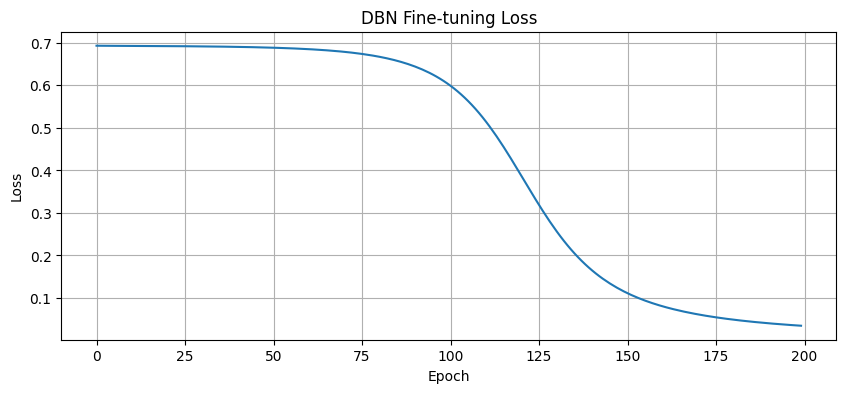

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(finetune_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DBN Fine-tuning Loss')
plt.grid(True)
plt.show()

In [13]:
print("DBN Classification Results:")
print("="*60)
print(f"{'Pattern':<20} {'True Label':<12} {'Predicted':<12} {'Rounded':<10}")
print("-"*60)

predictions, h = dbn.forward(X_train)

correct = 0
for i in range(len(X_train)):
    true_label = int(y_train[i].item())
    pred_prob = predictions[i].item()
    pred_label = 1 if pred_prob > 0.5 else 0
    correct += (pred_label == true_label)
    
    pattern = str(X_train[i].int().tolist())
    print(f"{pattern:<20} {true_label:<12} {pred_prob:<12.4f} {pred_label:<10}")

print(f"\nAccuracy: {correct}/{len(X_train)} = {100*correct/len(X_train):.1f}%")
print("\n✓ DBN learned to classify patterns!")

DBN Classification Results:
Pattern              True Label   Predicted    Rounded   
------------------------------------------------------------
[1, 1, 0, 0]         0            0.0292       0         
[1, 0, 0, 0]         0            0.0384       0         
[0, 0, 1, 1]         1            0.9708       1         
[0, 0, 0, 1]         1            0.9618       1         

Accuracy: 4/4 = 100.0%

✓ DBN learned to classify patterns!


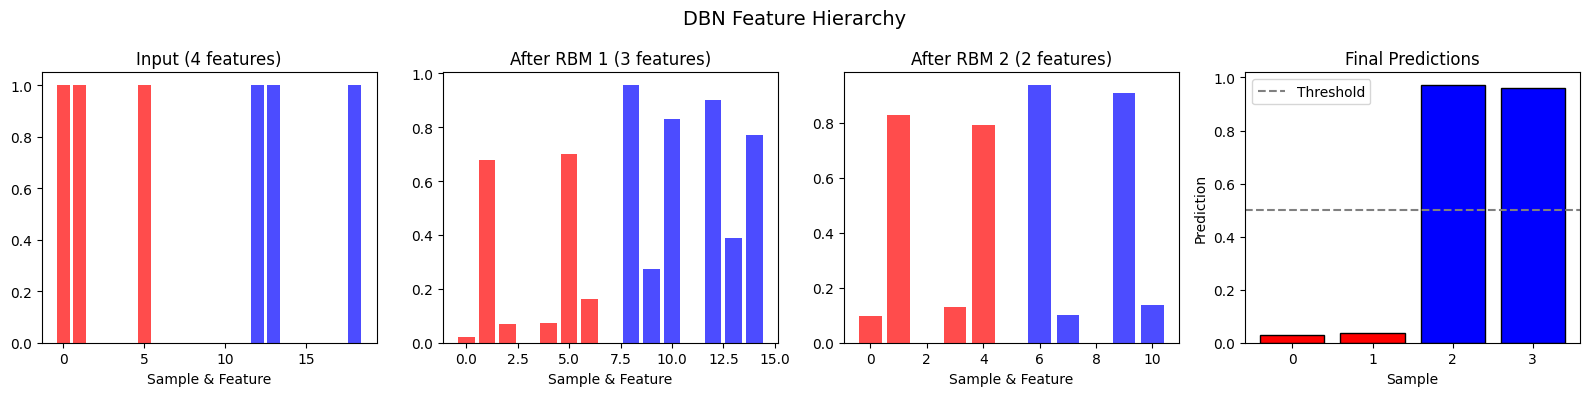

In [14]:
def visualize_dbn_pipeline(dbn, X, y):
    """Visualize DBN representations at each stage."""
    
    # Get activations
    h = X
    activations = [X]
    for rbm in dbn.rbms:
        h = rbm.transform(h)
        activations.append(h)
    
    predictions, _ = dbn.forward(X)
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    colors = ['red' if label == 0 else 'blue' for label in y]
    
    # Input
    for i in range(len(X)):
        axes[0].bar(np.arange(4) + i*5, X[i].numpy(), color=colors[i], alpha=0.7)
    axes[0].set_title('Input (4 features)')
    axes[0].set_xlabel('Sample & Feature')
    
    # After RBM 1
    h1 = activations[1].detach().numpy()
    for i in range(len(h1)):
        axes[1].bar(np.arange(3) + i*4, h1[i], color=colors[i], alpha=0.7)
    axes[1].set_title('After RBM 1 (3 features)')
    axes[1].set_xlabel('Sample & Feature')
    
    # After RBM 2
    h2 = activations[2].detach().numpy()
    for i in range(len(h2)):
        axes[2].bar(np.arange(2) + i*3, h2[i], color=colors[i], alpha=0.7)
    axes[2].set_title('After RBM 2 (2 features)')
    axes[2].set_xlabel('Sample & Feature')
    
    # Final predictions
    pred_np = predictions.detach().numpy().squeeze()
    axes[3].bar(range(4), pred_np, color=colors, edgecolor='black')
    axes[3].axhline(y=0.5, color='gray', linestyle='--', label='Threshold')
    axes[3].set_xlabel('Sample')
    axes[3].set_ylabel('Prediction')
    axes[3].set_title('Final Predictions')
    axes[3].legend()
    
    plt.suptitle('DBN Feature Hierarchy', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_dbn_pipeline(dbn, X_train, y_train)